In [1]:
version = 'v20250521'

## read in data

In [2]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

prop = 'soc'
tgt = 'soc_log1p'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/pnt_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)
test = pd.read_parquet(f'./material/pnt_test_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any').reset_index(drop=True)


## generate pnt prediction and uncertainty

In [3]:
# train the model
from trees_rf import cast_tree_rf, cast_node_rf, pad_leaf_outputs_to_array
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but")
model.fit(train[covs], train[tgt])

In [4]:
# generate prediction
y_pred = model.predict(test[covs])
y_pred = np.expm1(y_pred)
test[f'pred'] = y_pred

# cast the model
ttprint(f'start casting')
model = cast_node_rf(model, train[covs], train[tgt])

# generate uncertainty
ttprint(f'start predicting')
node_predictions = model.predict(test[covs])
nodes = pad_leaf_outputs_to_array(node_predictions, pad_value=np.nan)
nodes = nodes.T
ttprint(nodes.shape)
nodes = np.expm1(nodes)
test['pred_std'] = np.nanstd(nodes, axis=0)
ttprint(f'finish predicting')

[15:27:50] start casting
[15:28:03] start predicting
[15:28:29] (10132, 5400)
[15:28:30] finish predicting


In [5]:
test.loc[test['lc_survey']=='bareland', 'lc_survey'] = 'Bareland'
test.loc[test['lc_survey']=='wetland', 'lc_survey'] = 'Wetland'
test.loc[test['lc_survey']=='cropland', 'lc_survey'] = 'Cropland'
test.loc[test['lc_survey']=='woodland', 'lc_survey'] = 'Woodland'
test.loc[test['lc_survey']=='shrubland', 'lc_survey'] = 'Shrubland'
test.loc[test['lc_survey']=='grassland', 'lc_survey'] = 'Grassland'
test.loc[test['lc_survey']=='artificial land', 'lc_survey'] = 'Aritificial-land'

## organize soc pairs

In [6]:
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi_p50',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi_p50',
            'ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndvi_slope',
            'ndwi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndwi_slope'}

test = test.rename(columns = name_map)
            
for col in ['ndvi_p50','ndwi_p50']:
    test[col] = (test[col]-125)/125

In [7]:
tcol = ['lat', 'lon', 'time', 'soc', 'pred', 'pred_std', 'lc_survey','ndvi_p50','ndwi_p50'] # time series cols
scol = ['id', 'ref', 'nuts0', 'hzn_dep']

data_list = []
ttprint('start organizing')
for iid in test['id'].unique():
    temp = test.loc[test['id'] == iid].sort_values(by=['time'])  

    static_vals = temp.iloc[0][scol].tolist()  # Extract static values once

    if len(temp) == 2:
        ts_vals = [temp[itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

    elif len(temp) > 2:
        # Case with 3 points: form 3 pairs
        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

pair = pd.DataFrame(data_list, columns=scol + [i + '_pair' for i in tcol])
ttprint('finish organizing')

# organize features
pair['year_change'] = pair['time_pair'].str[1] - pair['time_pair'].str[0]
pair['soc_change'] = pair['soc_pair'].str[1] - pair['soc_pair'].str[0]
pair['pred_change'] = pair['pred_pair'].str[1] - pair['pred_pair'].str[0]
pair['noise'] = np.sqrt(pair['pred_std_pair'].str[1]**2 + pair['pred_std_pair'].str[0]**2)
pair['snr'] = pair['soc_change'].abs()/pair['noise']
pair['soc_mean'] = (pair['soc_pair'].str[1] + pair['soc_pair'].str[0])/2
pair['ndvi_mean'] = (pair['ndvi_p50_pair'].str[1] + pair['ndvi_p50_pair'].str[0])/2
pair['ndwi_mean'] = (pair['ndwi_p50_pair'].str[1] + pair['ndwi_p50_pair'].str[0])/2

[15:29:45] start organizing
[15:29:54] finish organizing


In [8]:
pair.to_parquet(f'./metric/pair_predicted.pnt_{version}.pq')

## evaluate prediction accuracy for SOC change

/tmp/ipykernel_94001/3773374273.py:70: RuntimeWarning: invalid value encountered in log1p
  ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)


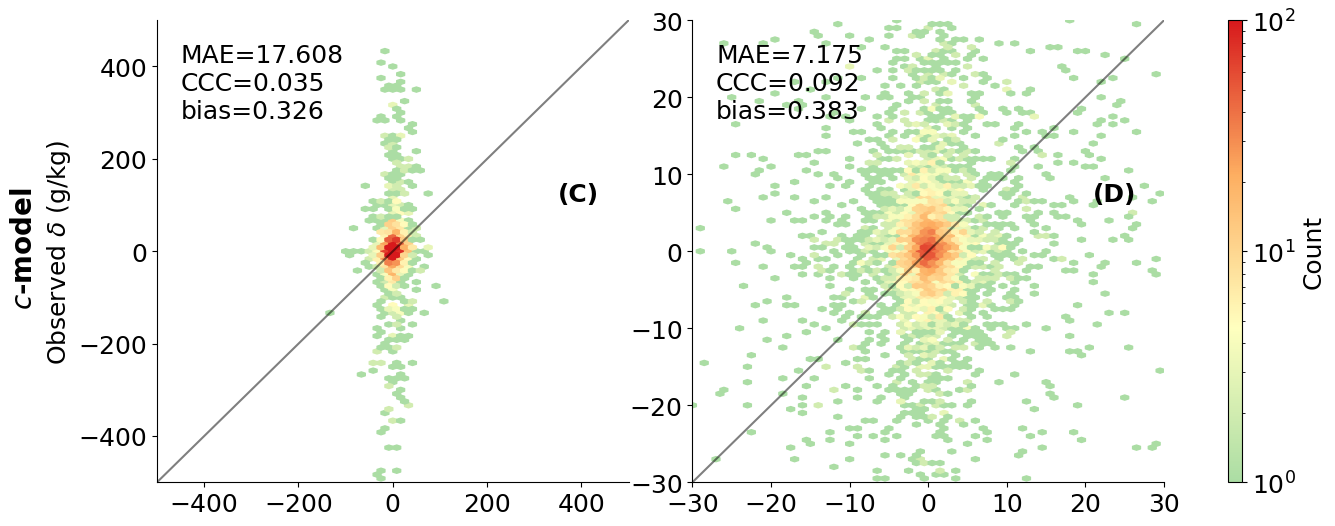

In [14]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from model_fit import calc_metrics
import math
import matplotlib.pyplot as plt

pair = pd.read_parquet(f'./metric/pair_predicted.pnt_{version}.pq')

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

vmax = 100
titles = ['Full range', 'Without outliers']

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# Subplot 1
show_range = [-500, 500]
ax1 = fig.add_subplot(gs[0])
y_t = pair['soc_change']
y_p = pair['pred_change']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb1 = ax1.hexbin(y_p, y_t, gridsize=(60, 60), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax1.set_xlabel('') #Predicted $\delta$ (g/kg)
ax1.set_ylabel('Observed $\delta$ (g/kg)')
ax1.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18)
ax1.text(0.85, 0.65, 
         f'(C)', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax1.plot(show_range, show_range, "-k", alpha=0.5)
ax1.set_xlim(show_range)
ax1.set_ylim(show_range)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subplot 2
show_range = [-30, 30]
ax2 = fig.add_subplot(gs[1])
y_t = pair.loc[pair['soc_change'].abs() < 30, 'soc_change']
y_p = pair.loc[pair['soc_change'].abs() < 30, 'pred_change']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb2 = ax2.hexbin(y_p, y_t, gridsize=(60, 60), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax2.set_xlabel('') #Predicted $\delta$ (g/kg)
ax2.set_ylabel(' ')
ax2.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18)
ax2.text(0.85, 0.65, 
         f'(D)', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)
ax2.set_xlim(show_range)
ax2.set_ylim(show_range)
ax2.plot(show_range, show_range, "-k", alpha=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Colorbar
cbar_ax = fig.add_subplot(gs[2])
cb = fig.colorbar(hb2, cax=cbar_ax)
cb.set_label('Count')
fig.text(0.03, 0.5,  r'$\it{c}$-model', va='center', ha='center', rotation='vertical', fontsize=20, fontweight='bold')
plt.savefig(f'./figure/plot_mdl.pnt_evaluation.change_pred.svg', bbox_inches='tight')
plt.show()


## change direction estimation

In [22]:
pair['direction_pred'] = ''
pair.loc[pair['pred_change']>=0, 'direction_pred'] = 'increase'
pair.loc[pair['pred_change']<0, 'direction_pred'] = 'decrease'

pair['direction_obsv'] = ''
pair.loc[pair['soc_change']>=0, 'direction_obsv'] = 'increase'
pair.loc[pair['soc_change']<0, 'direction_obsv'] = 'decrease'

In [23]:
from sklearn.metrics import f1_score, accuracy_score

y_true = pair['direction_obsv']
y_pred = pair['direction_pred']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, pos_label='increase')
print(f'accuracy: {accuracy}; f1: {f1}')

accuracy: 0.526; f1: 0.5698729582577132


### This is only a bit better than random guess

## coeffcient

In [31]:
coe = pair[['soc_mean','ndvi_mean','ndwi_mean','signal','noise','snr']].corr()

In [32]:
coe

,soc_mean,ndvi_mean,ndwi_mean,signal,noise,snr
soc_mean,1.000000,0.371747,0.343303,0.599567,0.587447,0.225444
ndvi_mean,0.371747,1.000000,0.913193,0.282375,0.635881,-0.048126
ndwi_mean,0.343303,0.913193,1.000000,0.260295,0.605829,-0.052871
signal,0.599567,0.282375,0.260295,1.000000,0.473851,0.542614
noise,0.587447,0.635881,0.605829,0.473851,1.000000,-0.038648
snr,0.225444,-0.048126,-0.052871,0.542614,-0.038648,1.000000


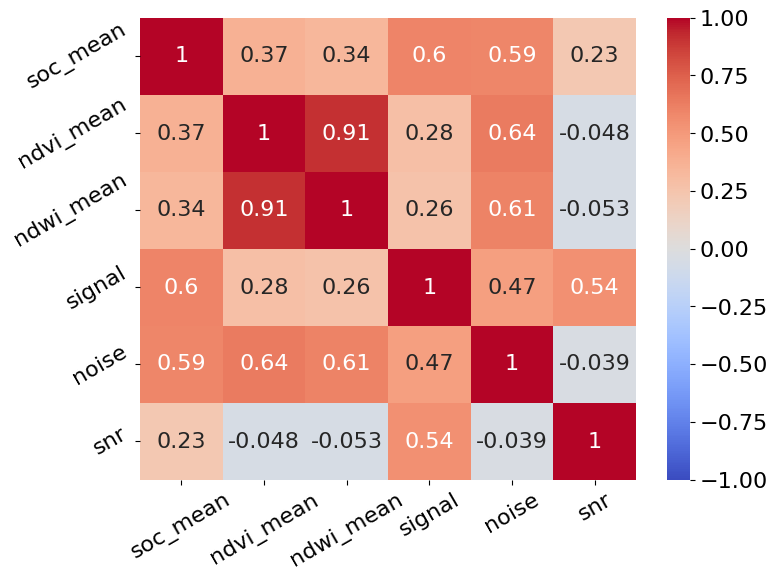

In [34]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()